# Analysis of Flight Delays
## Create by: Alexandre Benson Smith

## Investigation overview

The purpose of this investigation is to find out which characteristics are most related to the delay of a flight. The main point is time related factors, such as month, day of the month, day of the week, day of the week / weekend and time of scheduled arrival.

The delay analysis is based on arrival time delays, specifically A + 15 (arrival at the gate within 15 minutes of scheduled arrival), since this is the measure that the U.S. Department of Transportation (U.S.DOT) reports.

## Dataset overview

The investigation explored the U.S.DOT data set for 2007 flights in the U.S. This data set contains information about the punctual performance of airlines and flight delays. It covers nonstop scheduled service flights between points within the United States operated by 21 airlines.

There are 7,275,259 flights in the data set after cleaning.

In [1]:
# Import all packages and set plots to be embedded inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
import json
from timeit import default_timer as timer
import re
import matplotlib.pylab as pylab
%matplotlib inline

# Let's suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# Let's set default parameters for our plots
params = {'axes.labelsize': 13,
         'axes.titlesize': 15,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12}
pylab.rcParams.update(params)

In [2]:
# Load the dataset
df = pd.read_csv('cleaned_dataset.csv')

## Distribution of Delayed Flights
Only 24.8% of flights were delayed.Most airlines report time-related KPIs to the aviation authorities and airports in order to keep their operations.

In [3]:
# Function for the distribution of delayed flights
def barplot_delayed():
    table = df['Delayed'].value_counts().sort_index()/1e6
    X,title,ylabel = table, "Flight's Delayed Status", "Qty of Flights (in millions)" 
    fig, ax = plt.subplots(figsize=(15,6))
    X.plot.bar(color='steelblue')
    plt.title(title, fontweight="bold")
    plt.ylabel(ylabel)
    ax.set_ylabel(ylabel, labelpad=15)
    plt.xticks([0,1],["Not Delayed", "Delayed"], rotation=0)
    plt.xlabel('Flight\'s Status')
    for i,v in enumerate(['75.2%','24.8%']):
        ax.text(i-0.045, table.values[i]-0.2, v, color='white', fontweight="bold", size=12)
    return plt.show();

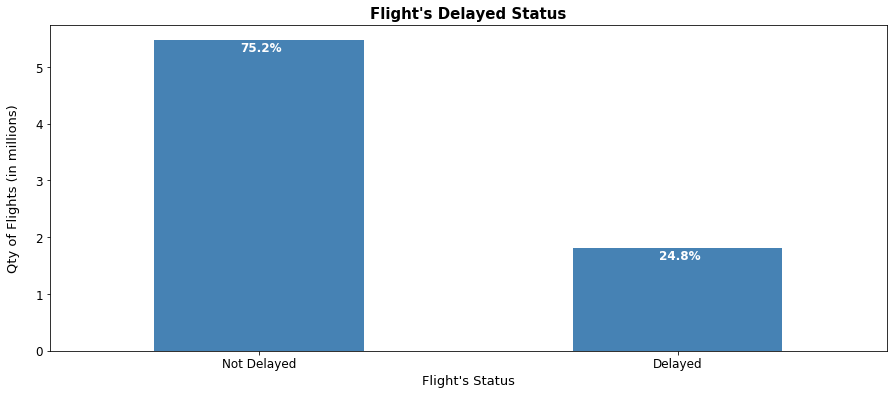

In [4]:
# Distribution of annual delayed flights
barplot_delayed()

## Delayed Flights through the months

The amount of delayed flights is always lower than the amount of not delayed flights throughout the months. There a little variance on the data

In [5]:
# Function to plot the amount of delayed and not delayed flights per month
def barplot_delayedmonth():
    cat1_order = list(range(1,13,1))
    cat1_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    cat2_order = [True, False]
    cat_var1 = 'Month'
    cat_var2 = 'Delayed'
    baselines = np.zeros(len(cat1_order))
    fig, ax = plt.subplots(figsize=(14, 5))
    plt.ylabel('Qty of Flights (in thousands)')
    plt.xlabel('Month', labelpad=10)
    plt.title('Flights per Month', fontweight="bold")
    colors = ['steelblue','gainsboro']
    artists = [] # for storing references to plot elements
    # for each second-variable category:
    for i in range(len(cat2_order)):
        # isolate the counts of the first category,
        cat2 = cat2_order[i]
        inner_counts = df[df[cat_var2] == cat2][cat_var1].value_counts()
        # then plot those counts on top of the accumulated baseline
        bars = plt.bar(x = np.arange(len(cat1_order)), height = inner_counts[cat1_order],bottom = baselines,color=colors[i])
        artists.append(bars)
        baselines += inner_counts[cat1_order]
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.xticks(np.arange(len(cat1_order)), cat1_ticks)
    plt.yticks(np.arange(100000,700000,100000),np.arange(100,700,100))
    plt.legend(reversed(artists), reversed(cat2_order), framealpha = 1,
               bbox_to_anchor = (1, 0.5), loc = 6, title = cat_var2);

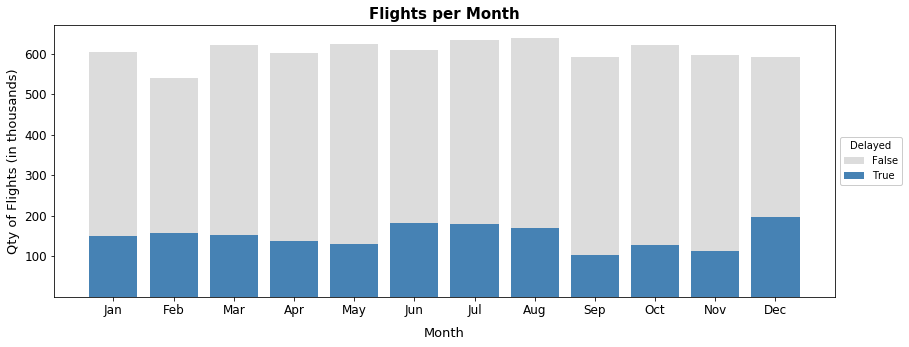

In [6]:
# Amount of delayed and not delayed flights per month
barplot_delayedmonth()

In [7]:
# Function to plot the amount of delayed and not delayed flights per scheduled arrival hour of each month
def barplot_hourmonth():
    labels = ['0 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM',
          '10 AM','11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
          '8 PM','9 PM','10 PM','11 PM']
    g = sns.FacetGrid(data = df, col = 'Month', col_wrap = 4, hue = 'Delayed', size = 3, palette = ['gainsboro','steelblue'])
    g.map(sns.countplot, "CRSArrivalTime", order=labels)
    plt.legend(title = 'Delayed', framealpha = 1, bbox_to_anchor = (1.1, 1.6), loc = 6)
    xticks = ['0 AM','','','3 AM','','','6 AM','','','9 AM',
          '','','12 PM','','','3 PM','','','6 PM','',
          '','9 PM','','']
    g.set_xticklabels(xticks,rotation=90, size=11)
    g.set_yticklabels(["",5,10,15,20,25,30,35])
    axes = g.axes.flatten()
    axes[4].set_ylabel("Amount of Flights (in thousands)")
    g.set_xlabels("")
    axes[9].set_xlabel("                                                Scheduled Arrival Hour", labelpad=10)
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Flights per Scheduled Arrival Hour of each Month', size=15, fontweight="bold")
    month_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(12):
        axes[i].set_title(month_ticks[i], size=14)
    
    plt.show();


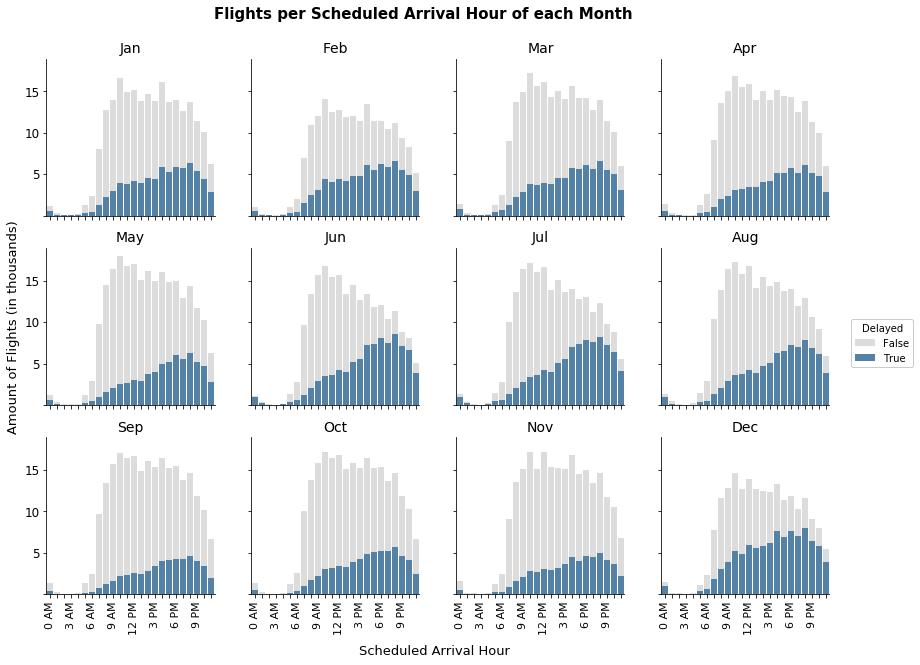

In [8]:
# Aamount of delayed and not delayed flights per scheduled arrival hour of each month
barplot_hourmonth()

In [9]:
# Function to plot the amount of delayed and not delayed flights each day of each month
def barplot_daymonth():
    bins = np.arange(1,31+2,1)
    g = sns.FacetGrid(data = df, col = 'Month', col_wrap = 4, hue = 'Delayed', palette = ['gainsboro','steelblue'])
    g.map(plt.hist, "DayOfMonth", bins=bins)

    plt.legend(title = 'Delayed', framealpha = 1, bbox_to_anchor = (1.1, 1.6), loc = 6)
    g.set_yticklabels(["",5,10,15])
    g.set_xticklabels(["",10,20,30])
    axes = g.axes.flatten()
    axes[4].set_ylabel("Amount of Flights (in thousands)")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Flights per Day of each Month', size=15, fontweight="bold")
    month_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(12):
        axes[i].set_title(month_ticks[i], size=14)
    g.set_xlabels("")
    axes[9].set_xlabel("                                                Day of Month", labelpad=10)
    g.set(ylim=(0, None))
    g.set(xlim=(0, None))
    plt.show();

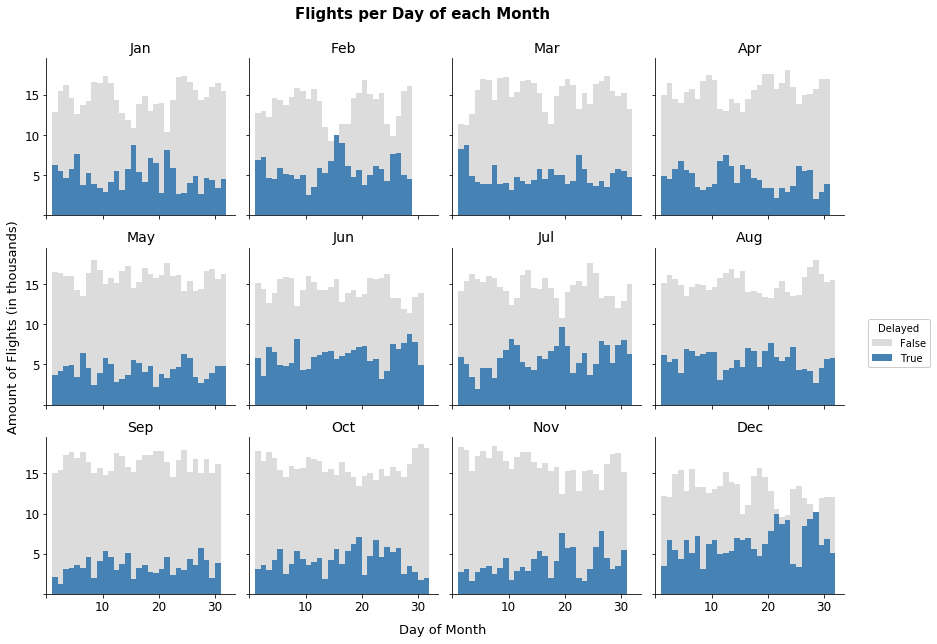

In [10]:
# Amount of delayed and not delayed flights each day of each month
barplot_daymonth()

In [11]:
# Function to plot the amount of delayed and not delayed flights each day of week of each month
def barplot_weekdaymonth():
    g = sns.FacetGrid(data = df, col = 'Month', col_wrap = 4, hue = 'Delayed', 
                      palette = ['gainsboro','steelblue'])
    g.map(sns.countplot, "DayOfWeek", 
          order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.legend(title = 'Delayed', framealpha = 1, bbox_to_anchor = (1.1, 1.6), loc = 6)
    xticks=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    g.set_xticklabels(xticks,rotation=90)
    g.set_yticklabels(["",20,40,60,80])
    axes = g.axes.flatten()
    axes[4].set_ylabel("Amount of Flights (in thousands)")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Flights per Day of Week of each Month', size=15, fontweight="bold")
    month_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(12):
        axes[i].set_title(month_ticks[i], size=14)
    g.set_xlabels("")
    axes[9].set_xlabel("                                                Day of Week", labelpad=10)
    plt.show();

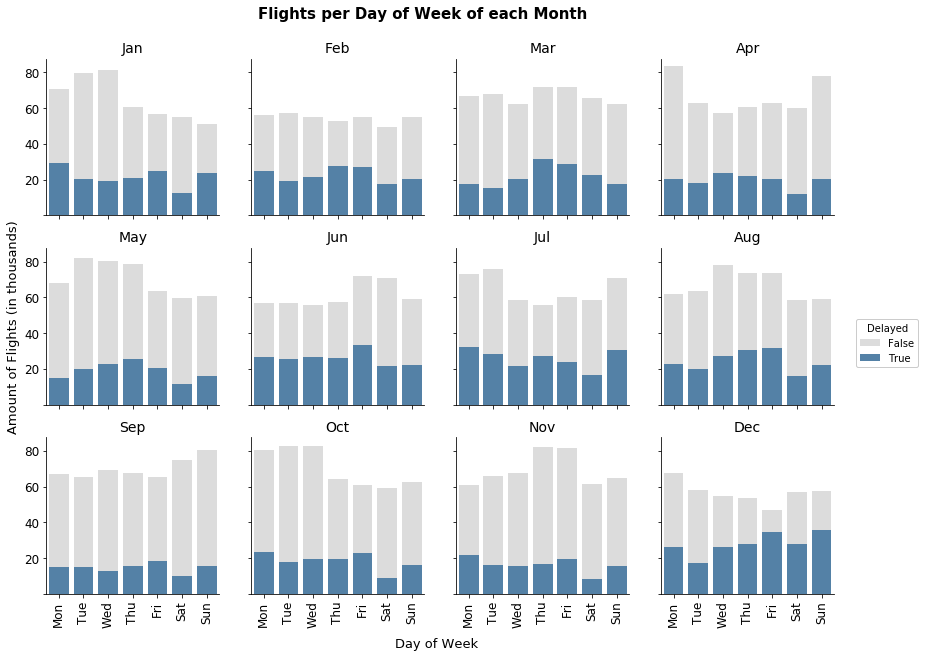

In [12]:
# Amount of delayed and not delayed flights each day of week of   each month
barplot_weekdaymonth()

In [13]:
# Function to plot the amount of delayed and not delayed flights each weekday/weekend of each month
def barplot_weekdayweekend():
    g = sns.FacetGrid(data = df, col = 'Month', col_wrap = 4, hue = 'Delayed', 
                      palette = ['gainsboro','steelblue'])
    g.map(sns.countplot, "Weekday_Weekend", order=['Weekday', 'Weekend'])
    plt.legend(title = 'Delayed', framealpha = 1, bbox_to_anchor = (1.1, 1.6), loc = 6)
    g.set_yticklabels(["",100,200,300])
    axes = g.axes.flatten()
    axes[4].set_ylabel("Amount of Flights (in thousands)")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Flights per Weekday/Weekend of each Month', size=15, fontweight="bold")
    month_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    for i in range(12):
        axes[i].set_title(month_ticks[i], size=14)
    g.set_xlabels("")
    plt.show();

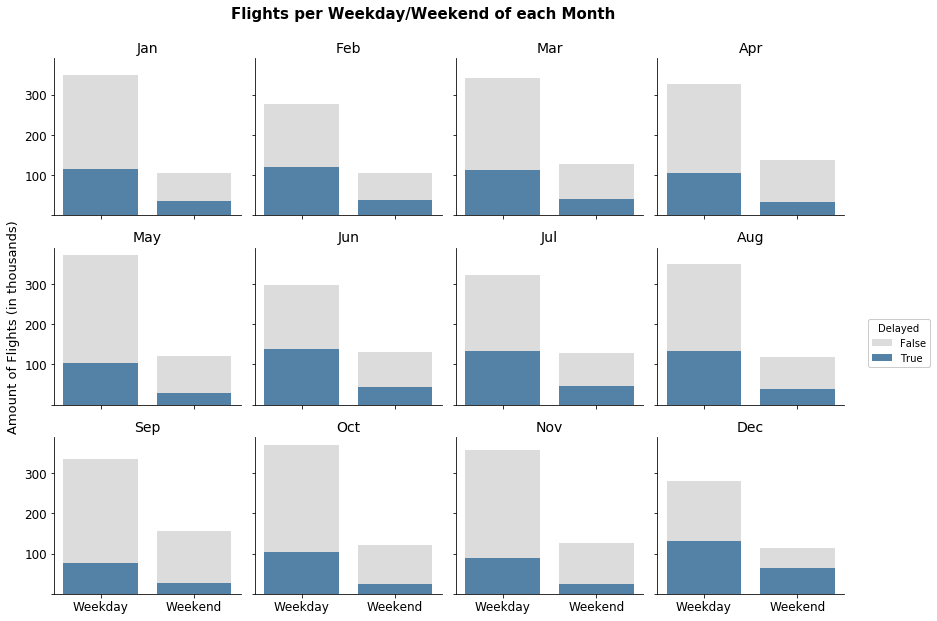

In [14]:
# Amount of delayed and not delayed flights each weekday/weekend  of each month
barplot_weekdayweekend()

## Percentage of Delayed Flights per hour 

There are more delays per hour between 9 PM and 0 AM, and a reduction in the percent of delays at 7 AM.

In [15]:
# Function for stacked bar chart, with relative frequency,  to plot the Percent of Flights per Scheduled Arrival Hour
def barplot_scheduledarrivalhour():
    cat1_order = ['0 AM','1 AM','2 AM','3 AM','4 AM','5 AM','6 AM','7 AM','8 AM','9 AM',
          '10 AM','11 AM','12 PM','1 PM','2 PM','3 PM','4 PM','5 PM','6 PM','7 PM',
          '8 PM','9 PM','10 PM','11 PM']
    cat2_order = [True, False]
    cat_var1 = 'CRSArrivalTime'
    cat_var2 = 'Delayed'
    ylabel, rotation =  'Percent of Flights', 90
    fig, ax = plt.subplots(figsize=(15, 5))
    plt.ylabel(ylabel)
    plt.xlabel('Scheduled Arrival Hour', labelpad=10)
    plt.title('Percent of Flights per Scheduled Arrival Hour', fontweight="bold")
    artists = [] # for storing references to plot elements
    baselines = np.zeros(len(cat1_order))
    cat1_counts = df[cat_var1].value_counts()
    colors = ['steelblue', 'gainsboro']
    # for each second-variable category:
    for i in range(len(cat2_order)):
        # isolate the counts of the first category,
        cat2 = cat2_order[i]
        inner_counts = df[df[cat_var2] == cat2][cat_var1].value_counts()
        inner_props = inner_counts / cat1_counts
        # then plot those counts on top of the accumulated baseline
        bars = plt.bar(x = np.arange(len(cat1_order)),
                       height = inner_props[cat1_order],
                       bottom = baselines, color=colors[i])
        artists.append(bars)
        baselines += inner_props[cat1_order]
        
        for r in bars:
            h = r.get_height()
            if (h>=0.34 or h<0.13) and i==0:
                plt.text(r.get_x() + r.get_width()/2., h-0.05, '{:,.2f}'.format(h), ha="center", color='gainsboro',fontweight="bold") 

            
    plt.xticks(np.arange(len(cat1_order)), cat1_order, rotation=rotation)
    plt.legend(reversed(artists), reversed(cat2_order), framealpha = 1,
               bbox_to_anchor = (1, 0.5), loc = 6, title = cat_var2);

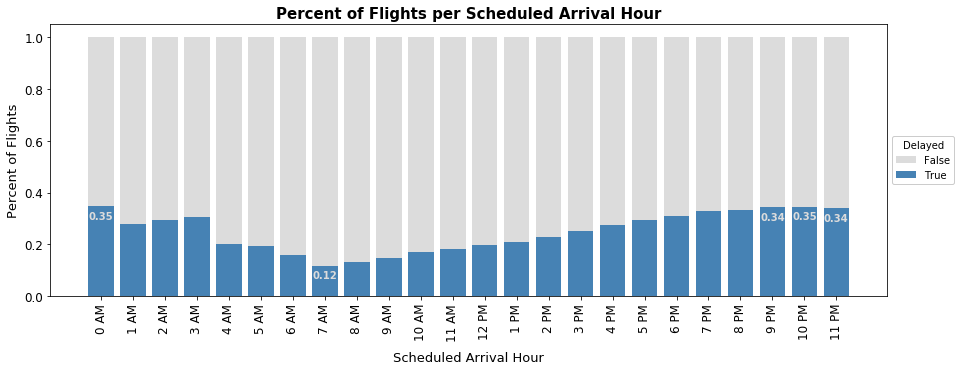

In [16]:
# Percent of Flights per Scheduled Arrival Hour
barplot_scheduledarrivalhour()

## Percentage of Delayed Flights per day of week 

Saturday has the lowest percent of delayed flights.

In [17]:
# Function for stacked bar chart, with relative frequency, to plot the Percent of Flights per Day of Week
def barplot_weekday():
    cat1_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    cat2_order = [True, False]
    cat_var1 = 'DayOfWeek'
    cat_var2 = 'Delayed'
    ylabel, rotation =  'Percent of Flights', 0
    fig, ax = plt.subplots(figsize=(14, 5))
    plt.ylabel(ylabel)
    plt.xlabel('Day of Week', labelpad=10)
    plt.title('Percent of Flights per Day of Week', fontweight="bold")
    artists = [] # for storing references to plot elements
    baselines = np.zeros(len(cat1_order))
    cat1_counts = df[cat_var1].value_counts()
    colors = ['steelblue', 'gainsboro']
    # for each second-variable category:
    for i in range(len(cat2_order)):
        # isolate the counts of the first category,
        cat2 = cat2_order[i]
        inner_counts = df[df[cat_var2] == cat2][cat_var1].value_counts()
        inner_props = inner_counts / cat1_counts
        # then plot those counts on top of the accumulated baseline
        bars = plt.bar(x = np.arange(len(cat1_order)),
                       height = inner_props[cat1_order],
                       bottom = baselines, color=colors[i])
        artists.append(bars)
        baselines += inner_props[cat1_order]
        
        for r in bars:
            h = r.get_height()
            if i==0:
                plt.text(r.get_x() + r.get_width()/2., h-0.05, '{:,.2f}'.format(h), ha="center", color='gainsboro',fontweight="bold") 

            
    plt.xticks(np.arange(len(cat1_order)), cat1_order, rotation=rotation)
    plt.legend(reversed(artists), reversed(cat2_order), framealpha = 1,
               bbox_to_anchor = (1, 0.5), loc = 6, title = cat_var2);

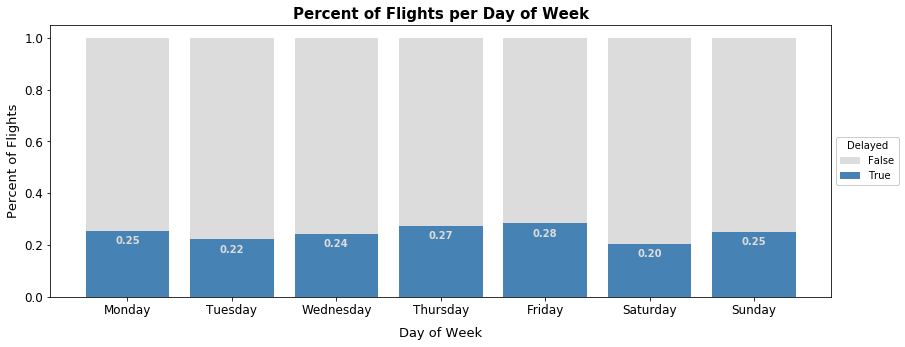

In [18]:
# Annual Percent of Flights per Day of Week
barplot_weekday()

## Percentage of Delayed Flights per weekday/weekend

Weekdays and weekends has similar delayed flightspercentage,being it slightly higher on weekdays.

In [19]:
# Function for stacked bar chart, with relative frequency, to plot the Percent of Flights per Weekday/Weekend
def barplot_prcent_weekdayweekend():
    cat1_order = ['Weekday', 'Weekend']
    cat2_order = [True, False]
    cat_var1 = 'Weekday_Weekend'
    cat_var2 = 'Delayed'
    ylabel, rotation =  'Percent of Flights', 0
    fig, ax = plt.subplots(figsize=(14, 5))
    plt.ylabel(ylabel)
    plt.title('Percent of Flights per Weekday/Weekend', fontweight="bold")
    artists = [] # for storing references to plot elements
    baselines = np.zeros(len(cat1_order))
    cat1_counts = df[cat_var1].value_counts()
    colors = ['steelblue', 'gainsboro']
    # for each second-variable category:
    for i in range(len(cat2_order)):
        # isolate the counts of the first category,
        cat2 = cat2_order[i]
        inner_counts = df[df[cat_var2] == cat2][cat_var1].value_counts()
        inner_props = inner_counts / cat1_counts
        # then plot those counts on top of the accumulated baseline
        bars = plt.bar(x = np.arange(len(cat1_order)),
                       height = inner_props[cat1_order],
                       bottom = baselines, color=colors[i])
        artists.append(bars)
        baselines += inner_props[cat1_order]
        
        for r in bars:
            h = r.get_height()
            if i==0:
                plt.text(r.get_x() + r.get_width()/2., h-0.05, '{:,.2f}'.format(h), ha="center", color='gainsboro',fontweight="bold") 

            
    plt.xticks(np.arange(len(cat1_order)), cat1_order, rotation=rotation)
    plt.legend(reversed(artists), reversed(cat2_order), framealpha = 1,
               bbox_to_anchor = (1, 0.5), loc = 6, title = cat_var2);

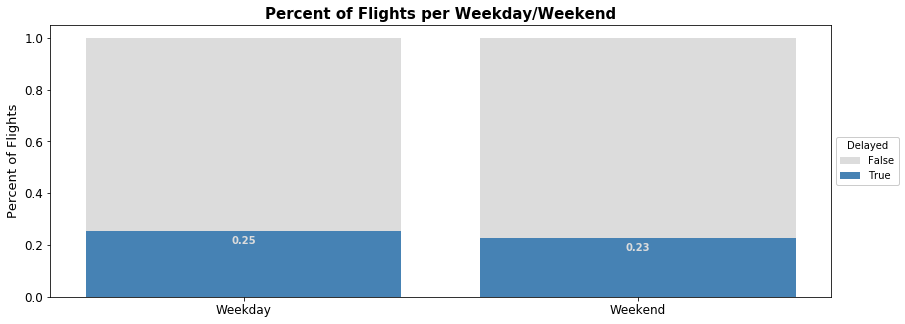

In [20]:
# Annual Percent of Flights per Weekday/Weekend
barplot_prcent_weekdayweekend()

## References:
- Matplotlib Colors: https://matplotlib.org/examples/color/named_colors.html
- Matplotlib Legend: https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.legend.html